------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------


# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification.

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case.

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical.
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


## Preparing the data

Let's first download the data set and take a look.

In [1]:
import math
import random
import re
import time
from collections import Counter, OrderedDict, defaultdict, namedtuple
from typing import Dict, List, Set, Tuple, Union

import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch import nn, optim

plt.style.use("default")

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
torch.manual_seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device", device)

Using device cuda


In [4]:
try:
    from wandb import wandb
except ImportError:
    !pip install wandb

Experiment config

In [5]:
USE_GOOGLE = False
LARGER_BATCH_SIZE = False
USE_CLASS_WEIGHTS = False
USE_SHORT_DATASET = True
USE_LONG_DATASET = False
TEST_WORD_ORDER = False

In [6]:
LAST_MODEL = None

In [7]:
if LARGER_BATCH_SIZE:
    BATCH_SIZE = 250
    NUM_STEPS = 3000
else:
    BATCH_SIZE = 250
    NUM_STEPS = 3000

NUM_STEPS_UNBATCHED = 30000

In [8]:
HYPOTHESIS = ""

if USE_CLASS_WEIGHTS:
    HYPOTHESIS += "-class_weights"
if LARGER_BATCH_SIZE:
    HYPOTHESIS += "-larger_batch_size"
if USE_SHORT_DATASET:
    HYPOTHESIS += "-short_dataset"
if USE_LONG_DATASET:
    HYPOTHESIS += "-long_dataset"
if USE_GOOGLE:
    HYPOTHESIS += "-google_embeddings"
if TEST_WORD_ORDER:
    HYPOTHESIS += "-test_word_order"

In [9]:
# TO PREVENT WANDB FROM RUNNING DISABLE IT HERE
USE_WANDB = True
# every test run will run three times unless you change this to 1
RUNS = 3

In [10]:
# !wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
# !unzip trainDevTestTrees_PTB.zip

In [11]:
LABELS = ["negative", "somewhat negative", "neutral", "somewhat positive", "positive"]

In [12]:
# this function reads in a textfile and fixes an issue with "\\"


def filereader(path):
    with open(path, mode="r", encoding="utf-8") as f:
        for line in f:
            yield line.strip().replace("\\", "")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [13]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [14]:
# We can use NLTK to better visualise the tree structure of the sentence

tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [15]:
# Let's first make a function that extracts the tokens (the leaves).


def tokens_from_treestring(s):
    """extract the tokens from a sentiment tree"""
    return re.sub(r"\([0-9] |\)", "", s).split()


# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [16]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
    s = re.sub("\([0-5] ([^)]+)\)", "0", s)
    s = re.sub("\)", " )", s)
    s = re.sub("\([0-4] ", "", s)
    s = re.sub("\([0-4] ", "", s)
    s = re.sub("\)", "1", s)
    return list(map(int, s.split()))

In [17]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
    print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [18]:
# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def extract_subtrees(tree_string):
    # Remove the top-level tree enclosure
    tree_string = tree_string[2:-1]

    subtrees = []
    balance = 0
    subtree_start = None

    for i, char in enumerate(tree_string):
        if char == "(":
            balance += 1
            if balance == 1:
                # Mark the start of a new subtree
                subtree_start = i
        elif char == ")":
            balance -= 1
            if balance == 0 and subtree_start is not None:
                # Complete the subtree if it's more than a single token
                if i - subtree_start > 1:
                    subtrees.append(tree_string[subtree_start : i + 1])
                subtree_start = None

    return subtrees


def examplereader(path, lower=False, create_subtrees=False):
    """Returns all examples in a file one by one."""
    for line in filereader(path):
        line = line.lower() if lower else line
        yield create_example(line)

        if create_subtrees:
            subtrees = extract_subtrees(line)
            for tree in subtrees:
                yield create_example(tree)


def create_example(tree_string):
    tokens = tokens_from_treestring(tree_string)
    tree = Tree.fromstring(tree_string)  # use NLTK's Tree
    label = int(tree_string[1])
    trans = transitions_from_treestring(tree_string)
    return Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


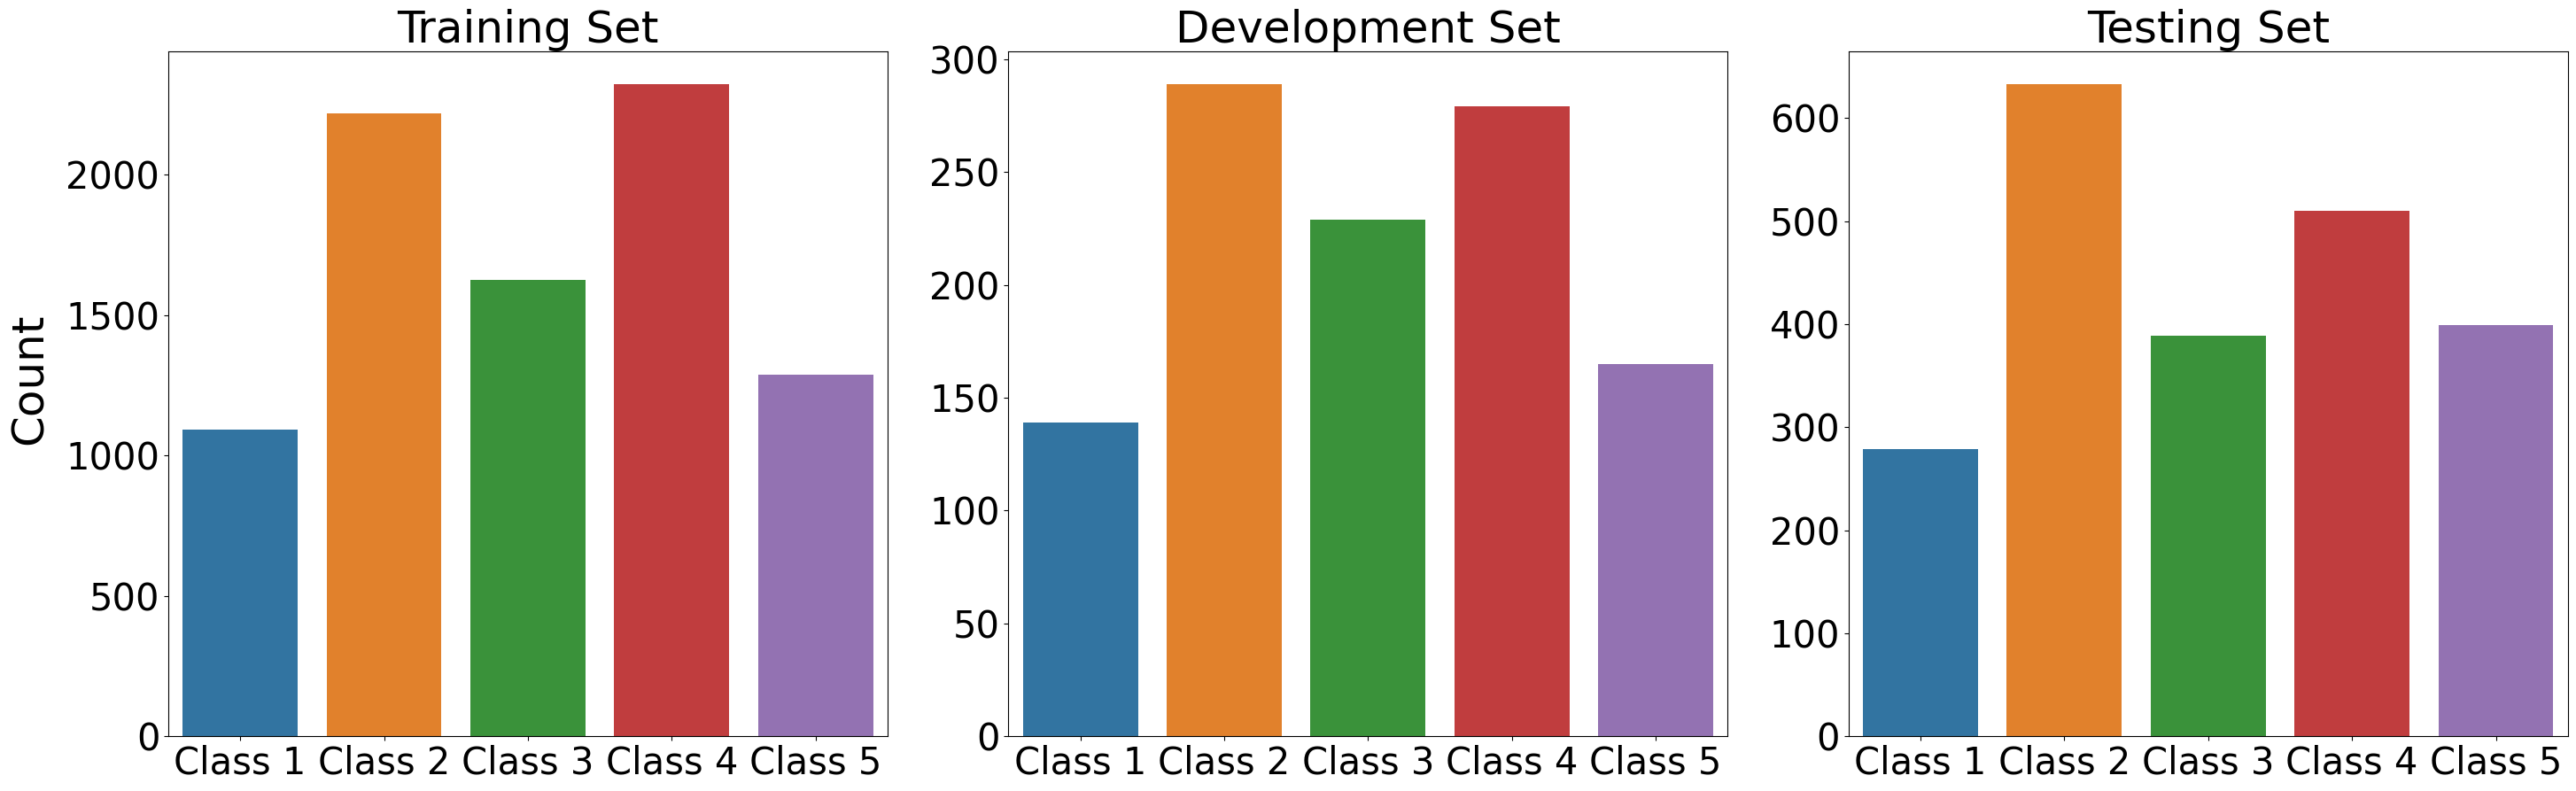

In [19]:
matplotlib.rcParams.update({"font.size": 30})

# let's checkout the label distribution
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

LABELS_ = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

# Plot countplots
sns.countplot(x=[LABELS_[e.label] for e in train_data], ax=axes[0], order=LABELS_)
axes[0].set_title("Training Set")
axes[0].set(ylabel="")
axes[0].set(xlabel="")

sns.countplot(x=[LABELS_[e.label] for e in dev_data], ax=axes[1], order=LABELS_)
axes[1].set_title("Development Set")
axes[1].set(ylabel="")

sns.countplot(x=[LABELS_[e.label] for e in test_data], ax=axes[2], order=LABELS_)
axes[2].set_title("Testing Set")
axes[2].set(ylabel="")

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.87, left=0.08)

fig.supylabel("Count")

# Show the plot
plt.savefig("figures/label_distribution.pdf", dpi=300)

Mean sequence length of training set: 19.143960674157302
Mean sequence length of dev set: 19.322434150772025
Mean sequence length of test set: 19.187782805429865


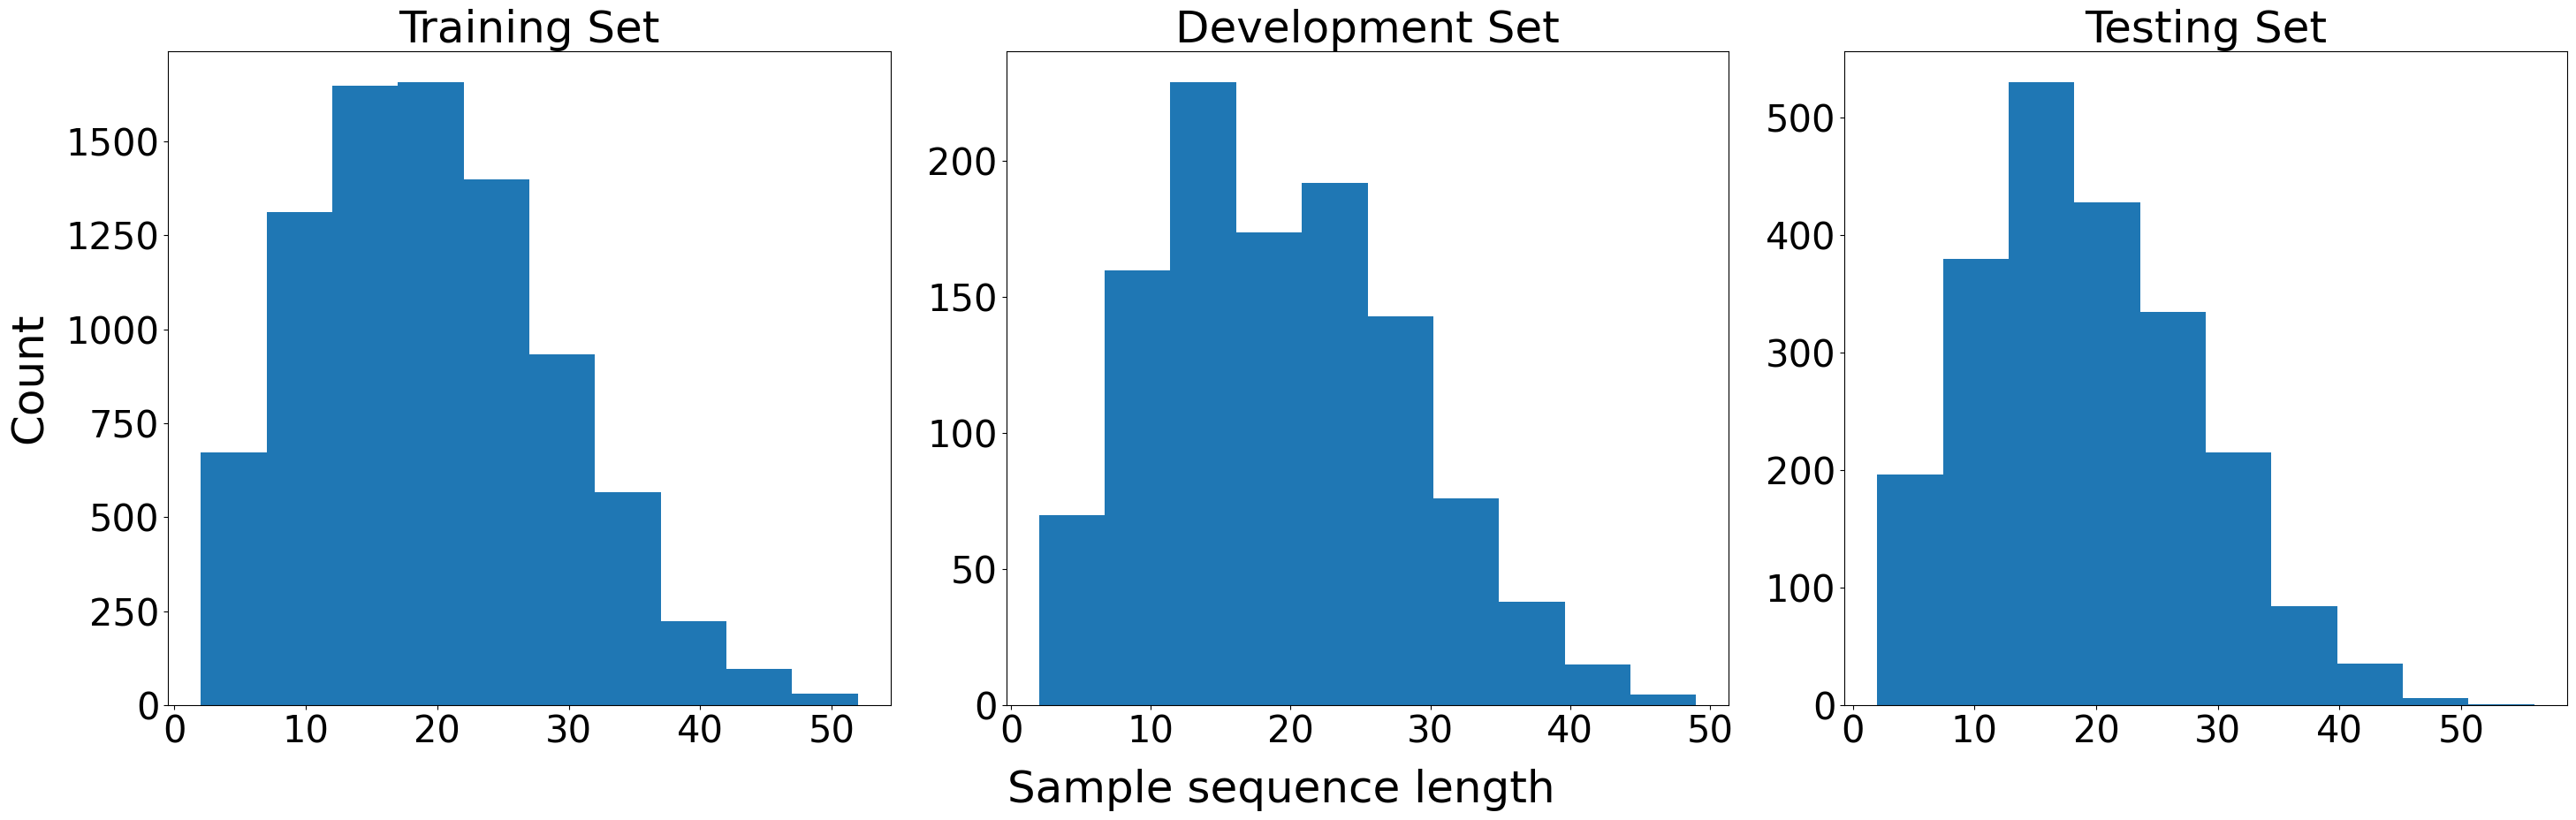

In [20]:
# additionally, let's visualise the sequence len distribution

# let's checkout the label distribution
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot countplots
train_seq_lens = [len(e.tokens) for e in train_data]
dev_seq_lens = [len(e.tokens) for e in dev_data]
test_seq_lens = [len(e.tokens) for e in test_data]

axes[0].hist(train_seq_lens)
axes[0].set_title("Training Set")

axes[1].hist(dev_seq_lens)
axes[1].set_title("Development Set")

axes[2].hist(test_seq_lens)
axes[2].set_title("Testing Set")

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.87, bottom=0.13, left=0.08)

fig.supxlabel("Sample sequence length")
fig.supylabel("Count")

# Show the plot
plt.savefig("figures/seq_len_distribution.pdf", dpi=300)

print("Mean sequence length of training set:", np.mean(train_seq_lens))
print("Mean sequence length of dev set:", np.mean(dev_seq_lens))
print("Mean sequence length of test set:", np.mean(test_seq_lens))

In [21]:
# based on the distributions above let's construct two additional test sets

SEQ_LEN_MEAN = 20

test_data_short = []
test_data_long = []

for e in test_data:
    if len(e.tokens) < SEQ_LEN_MEAN:
        test_data_short.append(e)
    else:
        test_data_long.append(e)

print("Test data short samples count:", len(test_data_short))
print("Test data long samples count:", len(test_data_long))

Test data short samples count: 1197
Test data long samples count: 1013


Let's check out an `Example` object.

In [22]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:", example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [23]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).


class OrderedCounter(Counter, OrderedDict):
    """Counter that remembers the order elements are first seen"""

    def __repr__(self):
        return "%s(%r)" % (self.__class__.__name__, OrderedDict(self))

    def __reduce__(self):
        return self.__class__, (OrderedDict(self),)


class Vocabulary:
    """A vocabulary, assigns IDs to tokens"""

    def __init__(self):
        self.freqs = OrderedCounter()
        self.w2i = {}
        self.i2w = []

    def count_token(self, t):
        self.freqs[t] += 1

    def add_token(self, t):
        self.w2i[t] = len(self.w2i)
        self.i2w.append(t)

    def build(self, min_freq=0):
        """
        min_freq: minimum number of occurrences for a word to be included
                in the vocabulary
        """
        self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
        self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

        tok_freq = list(self.freqs.items())
        tok_freq.sort(key=lambda x: x[1], reverse=True)
        for tok, freq in tok_freq:
            if freq >= min_freq:
                self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [24]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.


v = Vocabulary()
for data_set in (train_data,):
    for ex in data_set:
        for token in ex.tokens:
            v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [25]:
# What is the ID for "century?"
v.w2i["century"]

1973

In [26]:
# What are the first 10 words in the vocabulary (based on their IDs)?
v.i2w[:10]

['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]

In [27]:
# What are the 10 most common words?
v.freqs.most_common(10)

[('.', 8024),
 (',', 7131),
 ('the', 6037),
 ('and', 4431),
 ('a', 4403),
 ('of', 4386),
 ('to', 2995),
 ("'s", 2544),
 ('is', 2536),
 ('that', 1915)]

In [28]:
# And how many words are there with frequency 1?
# (A fancy name for these is hapax legomena.)

v.freqs.most_common()[-10:]

[('near-miss', 1),
 ('Flat', 1),
 ('Rashomon-for-dipsticks', 1),
 ('Bearable', 1),
 ('Staggeringly', 1),
 ('Well-made', 1),
 ('mush-hearted', 1),
 ('hippie-turned-yuppie', 1),
 ('muttering', 1),
 ('dissing', 1)]

In [29]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.
# You could use the `choice` function from the already imported `random` package

random.choices(v.i2w, k=20)

['clone',
 'summer',
 'Margarita',
 'regarding',
 'voices-from-the-other-side',
 'streaks',
 'extrusion',
 'achievement',
 'delusional',
 'head',
 'heads',
 'ascension',
 'actor',
 'Lambs',
 'trim',
 'launching',
 'frank',
 'brat',
 'addiction',
 'many']

#### Sentiment label vocabulary

In [30]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [31]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p: i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i["very positive"])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


In [32]:
# setting traing set

if TEST_WORD_ORDER:
    shuffled_train_data = []
    # shuffle the training data tokens
    for example in train_data:
        tokens = example.tokens
        random.shuffle(tokens)
        shuffled_train_data.append(
            Example(
                tokens=tokens,
                tree=example.tree,
                label=example.label,
                transitions=example.transitions,
            )
        )
    train_data = shuffled_train_data

In [33]:
# setting the test set
if USE_SHORT_DATASET:
    test_data = test_data_short
elif USE_LONG_DATASET:
    test_data = test_data_long
else:
    test_data = test_data

In [34]:
# constructing class weights

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique([e.label for e in train_data]),
    y=[e.label for e in train_data],
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

Class weights: tensor([1.5648, 0.7704, 1.0522, 0.7359, 1.3267])


# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [35]:
class BOW(nn.Module):
    """A simple bag-of-words model"""

    def __init__(self, vocab_size, embedding_dim, vocab):
        super(BOW, self).__init__()
        self.vocab = vocab

        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # this is a trainable bias term
        self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

    def forward(self, inputs):
        # this is the forward pass of the neural network
        # it applies a function to the input and returns the output

        # this looks up the embeddings for each word ID in inputs
        # the result is a sequence of word embeddings
        embeds = self.embed(inputs)

        # the output is the sum across the time dimension (1)
        # with the bias term added
        logits = embeds.sum(1) + self.bias

        return logits

In [36]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [37]:
# Here we print each parameter name, shape, and if it is trainable.


def print_parameters(model):
    total = 0
    for name, p in model.named_parameters():
        total += np.prod(p.shape)
        print(
            "{:24s} {:12s} requires_grad={}".format(
                name, str(list(p.shape)), p.requires_grad
            )
        )
    print("\nTotal number of parameters: {}\n".format(total))


print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [38]:
def prepare_example(example, vocab):
    """
    Map tokens to their IDs for a single example
    """

    # vocab returns 0 if the word is not there (i2w[0] = <unk>)
    x = [vocab.w2i.get(t, 0) for t in example.tokens]

    x = torch.LongTensor([x])
    x = x.to(device)

    y = torch.LongTensor([example.label])
    y = y.to(device)

    return x, y

In [39]:
x, y = prepare_example(dev_data[0], v)
print("x:", x)
print("y:", y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [40]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
    """Accuracy of a model on given data set."""
    correct = 0
    total = 0
    model.eval()  # disable dropout (explained later)

    targets = []
    predictions = []

    for example in data:
        # convert the example input and label to PyTorch tensors
        x, target = prep_fn(example, model.vocab)

        # forward pass without backpropagation (no_grad)
        # get the output from the neural network for input x
        with torch.no_grad():
            logits = model(x)

        # get the prediction
        prediction = logits.argmax(dim=-1)
        predictions.append(prediction.item())
        targets.append(target.item())

        # add the number of correct predictions to the total correct
        correct += (prediction == target).sum().item()
        total += 1

    return (
        correct,
        total,
        correct / float(total),
        f1_score(targets, predictions, average="weighted"),
        classification_report(targets, predictions, output_dict=True),
    )

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [41]:
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [42]:
def get_examples(data, shuffle=True, **kwargs):
    """Shuffle data set and return 1 example at a time (until nothing left)"""
    if shuffle:
        random.shuffle(data)
    for example in data:
        yield example

In [43]:
def train_model_(
    model_fn,
    optimizer=None,
    num_iterations=10000,
    print_every=1000,
    eval_every=1000,
    batch_fn=get_examples,
    prep_fn=prepare_example,
    eval_fn=simple_evaluate,
    batch_size=1,
    eval_batch_size=None,
    use_wandb=None,
    hypothesis=None,
    seed=42,
):
    model, optimizer = model_fn()
    
    if use_wandb is None:
        use_wandb = USE_WANDB

    if use_wandb:
        config = {
            "model": model.__class__.__name__,
            "optimizer": optimizer.__class__.__name__,
            "num_iterations": num_iterations,
            "batch_size": batch_size,
            "eval_batch_size": eval_batch_size,
            "seed": seed,
        }

        if hypothesis is not None:
            config.update({"hypothesis": hypothesis + HYPOTHESIS})

        wandb.init(
            project="nlp1-practical2",
            name=model.__class__.__name__ + "-" + str(int(time.time())),
            config=config,
        )

    """Train a model."""
    iter_i = 0
    train_loss = 0.0
    print_num = 0
    start = time.time()
    if USE_CLASS_WEIGHTS:
        print("Using class weights", class_weights)
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    best_eval = 0.0
    best_iter = 0

    # store train loss and validation accuracy during training
    # so we can plot them afterwards
    losses = []
    accuracies = []

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:  # when we run out of examples, shuffle and continue
        for batch in batch_fn(train_data, batch_size=batch_size):
            # forward pass
            model.train()
            x, targets = prep_fn(batch, model.vocab)
            logits = model(x)

            B = targets.size(0)  # later we will use B examples per update

            # compute cross-entropy loss (our criterion)
            # note that the cross entropy loss function computes the softmax for us
            loss = criterion(logits.view([B, -1]), targets.view(-1))
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print_num += 1
            iter_i += 1

            # print info
            if iter_i % print_every == 0:
                print(
                    "Iter %r: loss=%.4f, time=%.2fs"
                    % (iter_i, train_loss, time.time() - start)
                )
                losses.append(train_loss)
                if use_wandb:
                    wandb.log({"train_loss": train_loss})
                print_num = 0
                train_loss = 0.0

            # evaluate
            if iter_i % eval_every == 0:
                _, _, accuracy, dev_f1_score, _ = eval_fn(
                    model,
                    dev_data,
                    batch_size=eval_batch_size,
                    batch_fn=batch_fn,
                    prep_fn=prep_fn,
                )
                accuracies.append(accuracy)
                if use_wandb:
                    wandb.log({"dev_accuracy": accuracy})
                    wandb.log({"dev_f1_score": dev_f1_score})
                print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

                # save best model parameters
                if accuracy > best_eval:
                    print("new highscore")
                    best_eval = accuracy
                    best_iter = iter_i
                    path = "{}.pt".format(model.__class__.__name__)
                    ckpt = {
                        "state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_eval": best_eval,
                        "best_iter": best_iter,
                    }
                    torch.save(ckpt, path)

            # done training
            if iter_i == num_iterations:
                print("Done training")

                # evaluate on train, dev, and test with best model
                print("Loading best model")
                path = "{}.pt".format(model.__class__.__name__)
                ckpt = torch.load(path)
                model.load_state_dict(ckpt["state_dict"])

                _, _, train_acc, train_f1_score, _ = eval_fn(
                    model,
                    train_data,
                    batch_size=eval_batch_size,
                    batch_fn=batch_fn,
                    prep_fn=prep_fn,
                )
                _, _, dev_acc, dev_f1_score, _ = eval_fn(
                    model,
                    dev_data,
                    batch_size=eval_batch_size,
                    batch_fn=batch_fn,
                    prep_fn=prep_fn,
                )
                _, _, test_acc, test_f1_score, test_class_report = eval_fn(
                    model,
                    test_data,
                    batch_size=eval_batch_size,
                    batch_fn=batch_fn,
                    prep_fn=prep_fn,
                )
                
                global LAST_MODEL
                LAST_MODEL = model

                if use_wandb:
                    wandb.log({"final_train_accuracy": train_acc})
                    wandb.log({"final_train_f1_score": train_f1_score})
                    wandb.log({"final_dev_f1_score": dev_f1_score})
                    wandb.log({"final_dev_accuracy": dev_acc})
                    wandb.log({"test_accuracy": test_acc})
                    wandb.log({"test_f1_score": test_f1_score})
                    wandb.log({"test_classification_report": test_class_report})
                    wandb.finish()
                    time.sleep(5)

                print(
                    "best model iter {:d}: "
                    "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                        best_iter, train_acc, dev_acc, test_acc
                    )
                )

                return losses, accuracies


def train_model(**kwargs):
    losses = []
    accuracies = []
    for seed in range(RUNS):
        args = kwargs
        args["seed"] = seed
        set_seed(seed)

        losses_, accuracies_ = train_model_(**args)
        losses.append(losses_)
        accuracies.append(accuracies_)

    return losses[0], accuracies[0]

### Training the BOW model

In [44]:
# If everything is in place we can now train our first model!
def get_model():
    bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
    print(bow_model)

    bow_model = bow_model.to(device)
    optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)

    return bow_model, optimizer
    

bow_losses, bow_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS_UNBATCHED,
    print_every=NUM_STEPS_UNBATCHED // 30,
    eval_every=NUM_STEPS_UNBATCHED // 30,
    hypothesis="bow",
)

BOW(
  (embed): Embedding(18280, 5)
)


wandb: Currently logged in as: dqmiss. Use `wandb login --relogin` to force relogin


Iter 1000: loss=5887.2239, time=1.45s
iter 1000: dev acc=0.1889
new highscore
Iter 2000: loss=5599.4032, time=3.48s
iter 2000: dev acc=0.1953
new highscore
Iter 3000: loss=5235.8173, time=5.48s
iter 3000: dev acc=0.1998
new highscore
Iter 4000: loss=4656.1818, time=7.48s
iter 4000: dev acc=0.2107
new highscore
Iter 5000: loss=4723.8162, time=9.52s
iter 5000: dev acc=0.2134
new highscore
Iter 6000: loss=4464.1820, time=11.52s
iter 6000: dev acc=0.2153
new highscore
Iter 7000: loss=4477.2146, time=13.45s
iter 7000: dev acc=0.2162
new highscore
Iter 8000: loss=4534.3706, time=15.03s
iter 8000: dev acc=0.2134
Iter 9000: loss=4276.6309, time=16.19s
iter 9000: dev acc=0.2162
Iter 10000: loss=4048.7444, time=17.41s
iter 10000: dev acc=0.2216
new highscore
Iter 11000: loss=4052.8324, time=18.69s
iter 11000: dev acc=0.2271
new highscore
Iter 12000: loss=3906.6551, time=20.05s
iter 12000: dev acc=0.2289
new highscore
Iter 13000: loss=4114.5406, time=21.34s
iter 13000: dev acc=0.2307
new highscor

dev_accuracy,▁▂▂▄▄▄▄▄▄▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█
dev_f1_score,▁▂▃▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇█
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▇▆▅▅▅▅▅▄▄▄▃▄▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁
dev_accuracy,0.24705
dev_f1_score,0.23938


best model iter 30000: train acc=0.3088, dev acc=0.2470, test acc=0.2322
BOW(
  (embed): Embedding(18280, 5)
)


Iter 1000: loss=5468.5539, time=3.07s
iter 1000: dev acc=0.1780
new highscore
Iter 2000: loss=5395.9553, time=7.07s
iter 2000: dev acc=0.1744
Iter 3000: loss=4892.4902, time=11.42s
iter 3000: dev acc=0.1844
new highscore
Iter 4000: loss=4618.3548, time=15.78s
iter 4000: dev acc=0.1871
new highscore
Iter 5000: loss=4765.4554, time=20.19s
iter 5000: dev acc=0.2007
new highscore
Iter 6000: loss=4430.4141, time=24.51s
iter 6000: dev acc=0.2044
new highscore
Iter 7000: loss=4372.0018, time=28.86s
iter 7000: dev acc=0.2098
new highscore
Iter 8000: loss=4389.9773, time=33.28s
iter 8000: dev acc=0.2107
new highscore
Iter 9000: loss=4344.6841, time=37.12s
iter 9000: dev acc=0.2207
new highscore
Iter 10000: loss=4269.2003, time=41.51s
iter 10000: dev acc=0.2262
new highscore
Iter 11000: loss=4158.2494, time=45.88s
iter 11000: dev acc=0.2271
new highscore
Iter 12000: loss=3960.8651, time=50.39s
iter 12000: dev acc=0.2216
Iter 13000: loss=4188.9964, time=54.79s
iter 13000: dev acc=0.2298
new highs

dev_accuracy,▁▁▂▂▃▄▄▄▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇██
dev_f1_score,▁▁▂▃▄▄▄▄▅▆▆▅▆▆▆▆▆▆▇▇▇▇▇██▇▇▇██
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,██▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▃▂▃▂▂▂▁▂▂▁▁
dev_accuracy,0.25613
dev_f1_score,0.24999


best model iter 30000: train acc=0.3130, dev acc=0.2561, test acc=0.2598
BOW(
  (embed): Embedding(18280, 5)
)


Iter 1000: loss=4966.9761, time=3.05s
iter 1000: dev acc=0.1980
new highscore
Iter 2000: loss=4858.5450, time=6.99s
iter 2000: dev acc=0.2044
new highscore
Iter 3000: loss=4821.5402, time=10.96s
iter 3000: dev acc=0.2144
new highscore
Iter 4000: loss=4681.8356, time=15.49s
iter 4000: dev acc=0.2153
new highscore
Iter 5000: loss=4649.7223, time=20.00s
iter 5000: dev acc=0.2180
new highscore
Iter 6000: loss=4367.4997, time=24.51s
iter 6000: dev acc=0.2225
new highscore
Iter 7000: loss=4599.6737, time=29.00s
iter 7000: dev acc=0.2216
Iter 8000: loss=4358.1086, time=33.38s
iter 8000: dev acc=0.2271
new highscore
Iter 9000: loss=4206.6779, time=37.79s
iter 9000: dev acc=0.2252
Iter 10000: loss=4163.1152, time=41.64s
iter 10000: dev acc=0.2262
Iter 11000: loss=4226.9727, time=45.57s
iter 11000: dev acc=0.2298
new highscore
Iter 12000: loss=4056.4406, time=50.08s
iter 12000: dev acc=0.2298
Iter 13000: loss=3943.3022, time=54.56s
iter 13000: dev acc=0.2361
new highscore
Iter 14000: loss=3905.6

dev_accuracy,▁▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇██
dev_f1_score,▁▂▃▃▃▄▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,███▇▇▆▇▆▆▅▆▅▅▅▄▅▄▄▃▃▃▃▃▃▂▂▂▃▂▁
dev_accuracy,0.2634
dev_f1_score,0.2432


best model iter 30000: train acc=0.3160, dev acc=0.2634, test acc=0.2682


In [45]:
matplotlib.rcParams.update({"font.size": 12})

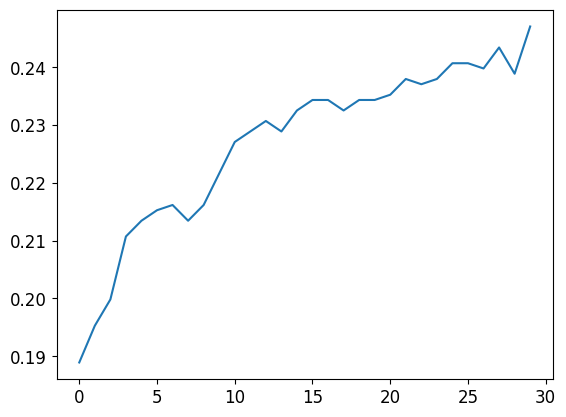

In [46]:
# This will plot the validation accuracies across time.
plt.plot(bow_accuracies)

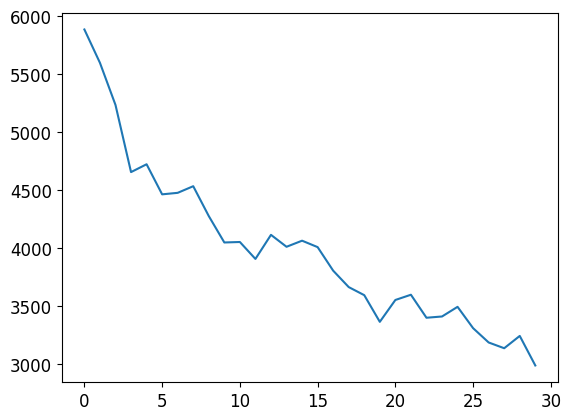

In [47]:
# This will plot the training loss over time.
plt.plot(bow_losses)

Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [48]:
class BOW(nn.Module):
    """A simple bag-of-words model"""

    def __init__(self, vocab_size, embedding_dim, vocab):
        super(BOW, self).__init__()
        self.vocab = vocab

        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # this is a trainable bias term
        self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

    def forward(self, inputs):
        # this is the forward pass of the neural network
        # it applies a function to the input and returns the output

        # this looks up the embeddings for each word ID in inputs
        # the result is a sequence of word embeddings
        embeds = self.embed(inputs)

        # the output is the sum across the time dimension (1)
        # with the bias term added
        logits = embeds.sum(1) + self.bias

        return logits

In [49]:
# YOUR CODE HERE


class CBOW(nn.Module):
    """A simple bag-of-words model"""

    def __init__(self, vocab_size, embedding_dim, output_dim, vocab):
        super(CBOW, self).__init__()
        self.vocab = vocab

        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # this is a trainable bias term
        self.linear1 = nn.Linear(embedding_dim, output_dim, bias=True)

    def forward(self, inputs):
        # this is the forward pass of the neural network
        # it applies a function to the input and returns the output

        # this looks up the embeddings for each word ID in inputs
        # the result is a sequence of word embeddings
        embeds = self.embed(inputs)

        # Projecting back to 5 dimensions using a linear layer
        out = self.linear1(embeds)
        out = out.sum(1)

        return out

In [50]:
vocab_size = len(v.w2i)
n_classes = len(t2i)


def get_model():
    cbow_model = CBOW(vocab_size, 300, n_classes, v)
    print(cbow_model)
    cbow_model = cbow_model.to(device)
    cbow_optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

    return cbow_model, cbow_optimizer


cbow_losses, cbow_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS_UNBATCHED,
    print_every=NUM_STEPS_UNBATCHED // 30,
    eval_every=NUM_STEPS_UNBATCHED // 30,
    hypothesis="cbow",
)

CBOW(
  (embed): Embedding(18280, 300)
  (linear1): Linear(in_features=300, out_features=5, bias=True)
)


Iter 1000: loss=2860.0631, time=4.89s
iter 1000: dev acc=0.2679
new highscore
Iter 2000: loss=2232.0625, time=11.07s
iter 2000: dev acc=0.2679
Iter 3000: loss=2105.5694, time=16.78s
iter 3000: dev acc=0.2589
Iter 4000: loss=2062.8901, time=22.95s
iter 4000: dev acc=0.2625
Iter 5000: loss=1977.3149, time=29.14s
iter 5000: dev acc=0.2925
new highscore
Iter 6000: loss=1911.0481, time=35.48s
iter 6000: dev acc=0.3052
new highscore
Iter 7000: loss=1863.2214, time=41.75s
iter 7000: dev acc=0.2906
Iter 8000: loss=1857.8702, time=47.66s
iter 8000: dev acc=0.2797
Iter 9000: loss=1701.7993, time=53.56s
iter 9000: dev acc=0.3070
new highscore
Iter 10000: loss=1572.6828, time=59.83s
iter 10000: dev acc=0.2852
Iter 11000: loss=1671.8934, time=66.04s
iter 11000: dev acc=0.3015
Iter 12000: loss=1636.6033, time=71.93s
iter 12000: dev acc=0.2816
Iter 13000: loss=1697.2366, time=78.09s
iter 13000: dev acc=0.2943
Iter 14000: loss=1624.9446, time=84.03s
iter 14000: dev acc=0.3270
new highscore
Iter 15000:

dev_accuracy,▂▂▁▁▄▅▃▃▅▃▄▃▄▆▆▇▆▅▆▅▆▅█▆▆█▇▇▇▇
dev_f1_score,▂▁▁▁▃▃▄▃▅▃▄▃▄▄▅▇▄▅▆▅▆▆█▅▆█▆▆▇▇
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▆▅▅▅▅▄▄▄▃▄▃▄▃▄▃▃▂▂▂▂▃▃▂▃▂▁▁▁▁
dev_accuracy,0.3297
dev_f1_score,0.32379


best model iter 23000: train acc=0.6821, dev acc=0.3506, test acc=0.3910
CBOW(
  (embed): Embedding(18280, 300)
  (linear1): Linear(in_features=300, out_features=5, bias=True)
)


Iter 1000: loss=2775.8077, time=5.69s
iter 1000: dev acc=0.2480
new highscore
Iter 2000: loss=2358.1398, time=13.65s
iter 2000: dev acc=0.2643
new highscore
Iter 3000: loss=2091.3309, time=22.40s
iter 3000: dev acc=0.2589
Iter 4000: loss=2049.4041, time=29.86s
iter 4000: dev acc=0.2661
new highscore
Iter 5000: loss=1947.0398, time=37.28s
iter 5000: dev acc=0.2834
new highscore
Iter 6000: loss=1893.5705, time=45.22s
iter 6000: dev acc=0.3052
new highscore
Iter 7000: loss=1919.0043, time=53.35s
iter 7000: dev acc=0.2988
Iter 8000: loss=1912.3389, time=61.14s
iter 8000: dev acc=0.2879
Iter 9000: loss=1709.9240, time=68.99s
iter 9000: dev acc=0.2779
Iter 10000: loss=1613.3857, time=76.45s
iter 10000: dev acc=0.2679
Iter 11000: loss=1608.7565, time=84.38s
iter 11000: dev acc=0.2997
Iter 12000: loss=1632.6638, time=92.04s
iter 12000: dev acc=0.3006
Iter 13000: loss=1706.6472, time=99.49s
iter 13000: dev acc=0.3252
new highscore
Iter 14000: loss=1597.8884, time=107.57s
iter 14000: dev acc=0.3

dev_accuracy,▁▂▂▂▃▅▅▄▃▂▅▅▆▇▄▆▆▅▅▆▇▆▇▆▅▆▄█▆▇
dev_f1_score,▁▃▃▃▄▅▅▅▄▄▆▅▆▇▅▆▆▆▆▆▇▆▇▆▆▆▆█▇▇
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▆▅▅▅▅▅▅▄▄▄▄▄▃▄▄▄▂▂▂▂▃▃▃▃▂▁▁▁▁
dev_accuracy,0.33697
dev_f1_score,0.32013


best model iter 28000: train acc=0.6752, dev acc=0.3479, test acc=0.3734
CBOW(
  (embed): Embedding(18280, 300)
  (linear1): Linear(in_features=300, out_features=5, bias=True)
)


Iter 1000: loss=2777.3888, time=4.87s
iter 1000: dev acc=0.2452
new highscore
Iter 2000: loss=2299.8719, time=12.76s
iter 2000: dev acc=0.2852
new highscore
Iter 3000: loss=2131.2826, time=20.90s
iter 3000: dev acc=0.2797
Iter 4000: loss=1998.8135, time=28.90s
iter 4000: dev acc=0.2761
Iter 5000: loss=1956.3128, time=35.40s
iter 5000: dev acc=0.2816
Iter 6000: loss=1892.4592, time=42.28s
iter 6000: dev acc=0.2979
new highscore
Iter 7000: loss=1823.9782, time=52.19s
iter 7000: dev acc=0.3052
new highscore
Iter 8000: loss=1864.4747, time=61.07s
iter 8000: dev acc=0.3152
new highscore
Iter 9000: loss=1700.3924, time=69.00s
iter 9000: dev acc=0.3270
new highscore
Iter 10000: loss=1606.8033, time=77.07s
iter 10000: dev acc=0.3134
Iter 11000: loss=1635.9066, time=84.65s
iter 11000: dev acc=0.3288
new highscore
Iter 12000: loss=1632.7630, time=92.48s
iter 12000: dev acc=0.2988
Iter 13000: loss=1667.7678, time=100.17s
iter 13000: dev acc=0.3306
new highscore
Iter 14000: loss=1609.1641, time=10

dev_accuracy,▁▄▃▃▃▄▅▆▆▆▇▅▇▆▇▇▆▇▇▇▇█▇▇▇█▇█▇█
dev_f1_score,▁▃▂▃▄▅▅▅▄▅▅▅▇▆▇▅▆▆▇▆▇▇▆█▆▇▇█▇▇
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▆▆▅▅▅▄▅▄▄▄▄▄▄▄▄▃▂▂▂▃▃▃▃▃▂▁▂▂▂
dev_accuracy,0.34605
dev_f1_score,0.3222


best model iter 28000: train acc=0.6821, dev acc=0.3506, test acc=0.3910


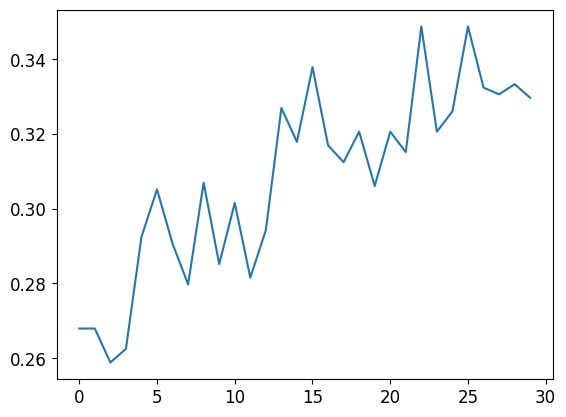

In [51]:
plt.plot(cbow_accuracies)

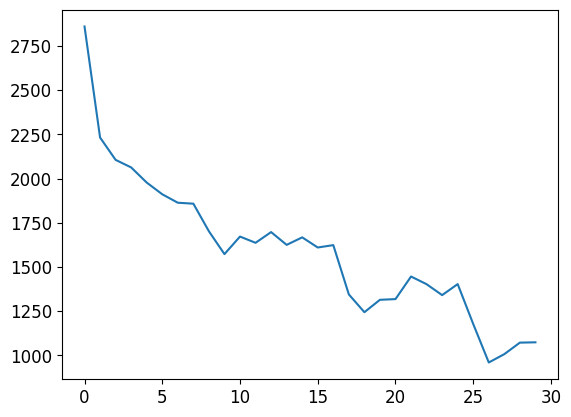

In [52]:
plt.plot(cbow_losses)

# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [53]:
# YOUR CODE HERE


class DeepCBOW(nn.Sequential):
    """A simple bag-of-words model"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
        super(DeepCBOW, self).__init__()
        self.vocab = vocab

        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # this is a trainable bias term
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim, bias=True),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim, bias=True),
        )

    def forward(self, inputs):
        # this is the forward pass of the neural network
        # it applies a function to the input and returns the output

        # this looks up the embeddings for each word ID in inputs
        # the result is a sequence of word embeddings
        embeds = self.embed(inputs)

        # the output is the small nn with 3 linear layers and 2 tanh activation layers
        out = self.model(embeds)
        out = out.sum(1)

        return out

In [54]:
vocab_size = len(v.w2i)
n_classes = len(t2i)


def get_model():
    deepcbow_model = DeepCBOW(vocab_size, 300, 100, n_classes, v)
    print(deepcbow_model)

    deepcbow_model = deepcbow_model.to(device)
    deepcbow_optimizer = optim.Adam(deepcbow_model.parameters(), lr=0.0005)

    return deepcbow_model, deepcbow_optimizer


deepcbow_losses, deepcbow_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS_UNBATCHED,
    print_every=NUM_STEPS_UNBATCHED // 30,
    eval_every=NUM_STEPS_UNBATCHED // 30,
    hypothesis="deepcbow",
)

DeepCBOW(
  (embed): Embedding(18280, 300)
  (model): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)


Iter 1000: loss=1758.0340, time=5.21s
iter 1000: dev acc=0.2452
new highscore
Iter 2000: loss=1668.0742, time=14.36s
iter 2000: dev acc=0.2634
new highscore
Iter 3000: loss=1644.5244, time=24.65s
iter 3000: dev acc=0.2452
Iter 4000: loss=1611.1397, time=32.60s
iter 4000: dev acc=0.3106
new highscore
Iter 5000: loss=1565.4282, time=40.99s
iter 5000: dev acc=0.2943
Iter 6000: loss=1545.0895, time=48.77s
iter 6000: dev acc=0.3261
new highscore
Iter 7000: loss=1569.3826, time=58.13s
iter 7000: dev acc=0.2897
Iter 8000: loss=1550.1434, time=65.33s
iter 8000: dev acc=0.3424
new highscore
Iter 9000: loss=1460.0559, time=73.35s
iter 9000: dev acc=0.3397
Iter 10000: loss=1395.4374, time=81.69s
iter 10000: dev acc=0.2997
Iter 11000: loss=1392.1623, time=89.75s
iter 11000: dev acc=0.3070
Iter 12000: loss=1411.7390, time=98.00s
iter 12000: dev acc=0.3170
Iter 13000: loss=1409.8364, time=105.97s
iter 13000: dev acc=0.3488
new highscore
Iter 14000: loss=1362.9116, time=114.97s
iter 14000: dev acc=0.

dev_accuracy,▁▂▁▄▄▅▃▆▆▄▄▅▆▇▇█▄▇▇▅▆▅▇▇█▇▇▇▆▆
dev_f1_score,▁▂▂▃▁▄▄▄▅▄▄▄▆▄▇▇▅▇▅▅▆▆▇▇█▇█▇▆▇
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▄▃▁▁▂▁
dev_accuracy,0.34151
dev_f1_score,0.33054


best model iter 16000: train acc=0.6147, dev acc=0.3769, test acc=0.4043
DeepCBOW(
  (embed): Embedding(18280, 300)
  (model): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)


Iter 1000: loss=1754.6661, time=4.03s
iter 1000: dev acc=0.2725
new highscore
Iter 2000: loss=1678.9758, time=10.36s
iter 2000: dev acc=0.2698
Iter 3000: loss=1636.4058, time=17.01s
iter 3000: dev acc=0.2734
new highscore
Iter 4000: loss=1605.4470, time=24.06s
iter 4000: dev acc=0.3015
new highscore
Iter 5000: loss=1561.6594, time=31.19s
iter 5000: dev acc=0.3025
new highscore
Iter 6000: loss=1544.0129, time=38.01s
iter 6000: dev acc=0.3143
new highscore
Iter 7000: loss=1538.7593, time=45.05s
iter 7000: dev acc=0.3252
new highscore
Iter 8000: loss=1558.0035, time=52.51s
iter 8000: dev acc=0.3188
Iter 9000: loss=1477.6821, time=59.20s
iter 9000: dev acc=0.3243
Iter 10000: loss=1404.4817, time=65.83s
iter 10000: dev acc=0.3479
new highscore
Iter 11000: loss=1399.4485, time=73.51s
iter 11000: dev acc=0.3406
Iter 12000: loss=1397.6824, time=80.17s
iter 12000: dev acc=0.3215
Iter 13000: loss=1393.2818, time=86.59s
iter 13000: dev acc=0.3751
new highscore
Iter 14000: loss=1358.0530, time=93.

dev_accuracy,▁▁▁▃▃▄▅▄▅▆▆▄█▄▅▃▄▇▆▅▆▆▆▆▇▄▆▅▆▄
dev_f1_score,▃▃▁▅▃▄▆▄▇▆▇▆▇▆▆▅▅▇█▇▇██▇▇▆█▇█▇
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▃▃▃▃▄▃▄▄▃▁▂▂▂
dev_accuracy,0.31971
dev_f1_score,0.31469


best model iter 13000: train acc=0.5049, dev acc=0.3787, test acc=0.3835
DeepCBOW(
  (embed): Embedding(18280, 300)
  (model): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)


Iter 1000: loss=1776.0884, time=5.02s
iter 1000: dev acc=0.2625
new highscore
Iter 2000: loss=1695.4578, time=11.78s
iter 2000: dev acc=0.2679
new highscore
Iter 3000: loss=1642.1369, time=18.58s
iter 3000: dev acc=0.2852
new highscore
Iter 4000: loss=1605.0436, time=25.64s
iter 4000: dev acc=0.3097
new highscore
Iter 5000: loss=1571.0025, time=32.63s
iter 5000: dev acc=0.3152
new highscore
Iter 6000: loss=1549.6496, time=39.46s
iter 6000: dev acc=0.3143
Iter 7000: loss=1523.6196, time=45.85s
iter 7000: dev acc=0.3288
new highscore
Iter 8000: loss=1535.2792, time=52.68s
iter 8000: dev acc=0.3333
new highscore
Iter 9000: loss=1484.9990, time=59.58s
iter 9000: dev acc=0.3388
new highscore
Iter 10000: loss=1387.9110, time=66.40s
iter 10000: dev acc=0.3397
new highscore
Iter 11000: loss=1377.1257, time=73.17s
iter 11000: dev acc=0.3470
new highscore
Iter 12000: loss=1374.6883, time=79.97s
iter 12000: dev acc=0.3370
Iter 13000: loss=1375.9465, time=86.55s
iter 13000: dev acc=0.3642
new high

dev_accuracy,▁▁▂▄▄▄▅▅▆▆▆▆▇▇▆▇▇▇▇▇▆▇▆▇█▇▆█▇▇
dev_f1_score,▂▁▃▅▃▄▄▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇█▇██
final_dev_accuracy,▁
final_dev_f1_score,▁
final_train_accuracy,▁
final_train_f1_score,▁
test_accuracy,▁
test_f1_score,▁
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▁▁▁▂
dev_accuracy,0.36149
dev_f1_score,0.3368


best model iter 25000: train acc=0.6147, dev acc=0.3769, test acc=0.4043


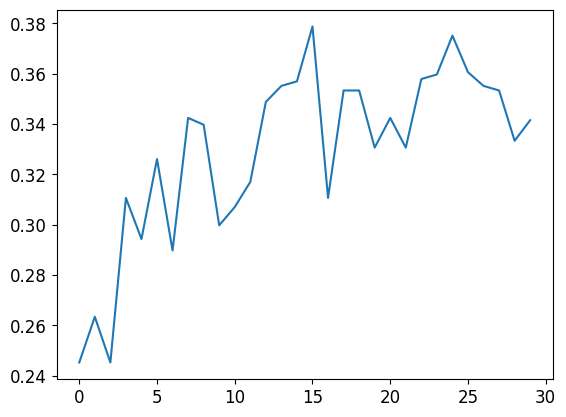

In [55]:
plt.plot(deepcbow_accuracies)

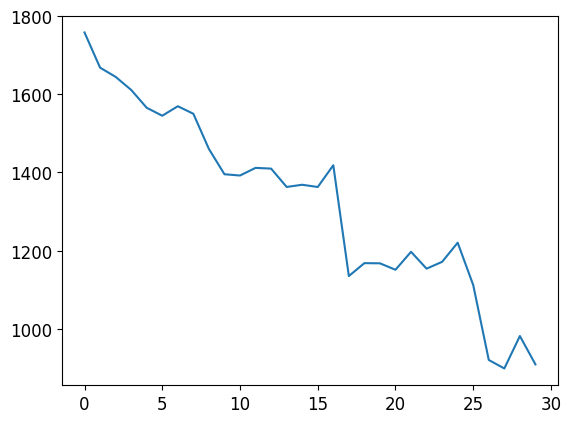

In [56]:
plt.plot(deepcbow_losses)

# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [57]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

# !wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

In [58]:
# This downloads the word2vec 300D Google News vectors
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
# !wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

In [59]:
# Mount Google Drive (to save the downloaded files)
# from google.colab import drive
# drive.mount('/gdrive')

In [60]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it.
#!cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
#!cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [61]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
# !cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
# !cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

In [62]:
# Uncomment these 2 lines below if went for the OPTIONAL method described above
# !cp "glove.840B.300d.sst.txt" "./"
# !cp "googlenews.word2vec.300d.txt" "./"

At this point you have the pre-trained word embedding files, but what do they look like?

In [63]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?

glove_embeddings: dict[str, np.ndarray] = {}
google_embeddings: dict[str, np.ndarray] = {}

with open("glove.840B.300d.sst.txt", mode="r", encoding="utf-8") as f:
    glove_embeddings = {
        line.split()[0]: np.array(line.split()[1:], dtype=np.float64) for line in f
    }

with open("googlenews.word2vec.300d.txt", mode="r", encoding="utf-8") as f:
    google_embeddings = {
        line.split()[0]: np.array(line.split()[1:], dtype=np.float64) for line in f
    }

for i, (k, v) in enumerate(glove_embeddings.items()):
    print(k, v[:5])
    if i == 3:
        break
for i, (k, v) in enumerate(google_embeddings.items()):
    print(k, v[:5])
    if i == 3:
        break

print()

print("Glove embeddings:\n")
print("Number of words:", len(glove_embeddings))
print("Embedding dimension:", len(next(iter(glove_embeddings.values()))))

print("-" * 30)

print("Google embeddings:\n")
print("Number of words:", len(google_embeddings))
print("Embedding dimension:", len(next(iter(google_embeddings.values()))))

print()
print(
    "Matching words between Glove and Google:",
    len(glove_embeddings.keys() & google_embeddings.keys()),
)

, [-0.082752  0.67204  -0.14987  -0.064983  0.056491]
. [ 0.012001  0.20751  -0.12578  -0.59325   0.12525 ]
the [ 0.27204  -0.06203  -0.1884    0.023225 -0.018158]
and [-0.18567   0.066008 -0.25209  -0.11725   0.26513 ]
in [0.0703125  0.08691406 0.08789062 0.0625     0.06933594]
for [-0.01177978 -0.04736328  0.04467773  0.06347656 -0.01818848]
that [-0.01574707 -0.02832031  0.08349609  0.05029297 -0.11035156]
is [ 0.00704956 -0.07324219  0.171875    0.02258301 -0.1328125 ]

Glove embeddings:

Number of words: 20725
Embedding dimension: 300
------------------------------
Google embeddings:

Number of words: 18920
Embedding dimension: 300

Matching words between Glove and Google: 18905


#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary.
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training.

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1,
 - and then all words in the pre-trained embedding set.


After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```

Remember to add new embeddings for the `<unk>` and `<pad>` tokens, as they're not part of the word2vec/GloVe embeddings. These embeddings can be randomly initialized or 0-valued, think about what makes sense and see what the effects are.


In [64]:
def construct_vocab_embeddings(
    pretrained_embeddings: Dict[str, np.ndarray]
) -> Tuple[Vocabulary, np.ndarray]:
    vocab = Vocabulary()
    vocab.build()
    embedding_dim = len(next(iter(pretrained_embeddings.values())))
    pretrained_embeddings_word_size = len(pretrained_embeddings)
    embeddings = np.random.normal(
        0, 1, size=(len(vocab.w2i) + pretrained_embeddings_word_size, embedding_dim)
    )
    for _, (word, embedding) in enumerate(pretrained_embeddings.items()):
        vocab.add_token(word)
        embeddings[vocab.w2i[word]] = embedding
    return vocab, embeddings


if USE_GOOGLE:
    v, vectors = construct_vocab_embeddings(google_embeddings)
else:
    v, vectors = construct_vocab_embeddings(glove_embeddings)
vectors.shape

(20727, 300)

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [65]:
dataset_tokens: List[Set[str]] = []
for data_set in (train_data, dev_data, test_data):
    tokens = set()
    for ex in data_set:
        for token in ex.tokens:
            tokens.add(token.lower())
    dataset_tokens.append(tokens)

for i, tokens in enumerate(dataset_tokens):
    print(
        "Number of unique tokens in {} set: {}".format(
            ["train", "dev", "test"][i], len(tokens)
        )
    )
    print(
        "Number of tokens in {} set that are in Glove: {}".format(
            ["train", "dev", "test"][i], len(tokens & glove_embeddings.keys())
        )
    )
    print(
        "Number of tokens in {} set that are in Google: {}".format(
            ["train", "dev", "test"][i], len(tokens & google_embeddings.keys())
        )
    )
    print(
        "Number of tokens in {} set that are not in Glove: {}".format(
            ["train", "dev", "test"][i], len(tokens - glove_embeddings.keys())
        )
    )
    print(
        "Number of tokens in {} set that are not in Google: {}".format(
            ["train", "dev", "test"][i], len(tokens - google_embeddings.keys())
        )
    )
    print()

Number of unique tokens in train set: 16579
Number of tokens in train set that are in Glove: 13454
Number of tokens in train set that are in Google: 12206
Number of tokens in train set that are not in Glove: 3125
Number of tokens in train set that are not in Google: 4373

Number of unique tokens in dev set: 5038
Number of tokens in dev set that are in Glove: 4328
Number of tokens in dev set that are in Google: 4098
Number of tokens in dev set that are not in Glove: 710
Number of tokens in dev set that are not in Google: 940

Number of unique tokens in test set: 3949
Number of tokens in test set that are in Glove: 3443
Number of tokens in test set that are in Google: 3236
Number of tokens in test set that are not in Glove: 506
Number of tokens in test set that are not in Google: 713



#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [66]:
# We define a new class that inherits from DeepCBOW.

class PTDeepCBOW(DeepCBOW):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
        super(PTDeepCBOW, self).__init__(
            vocab_size, embedding_dim, hidden_dim, output_dim, vocab
        )

In [67]:
# Create a Deep CBOW model with pre-trained embeddings
# YOUR CODE HERE
vocab_size = vectors.shape[0]
embedding_dim = vectors.shape[1]

def get_model():
    pt_deep_cbow_model = PTDeepCBOW(vocab_size, embedding_dim, 100, n_classes, v)
    pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))

    pt_deep_cbow_model.embed.weight.requires_grad = False
    pt_deep_cbow_model = pt_deep_cbow_model.to(device)
    pt_deep_cbow_optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)

    return pt_deep_cbow_model, pt_deep_cbow_optimizer

pt_deep_cbow__losses, pt_deep_cbow__accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS_UNBATCHED,
    print_every=NUM_STEPS_UNBATCHED // 30,
    eval_every=NUM_STEPS_UNBATCHED // 30,
    hypothesis="ptdeepcbow",
)

Iter 1000: loss=1588.9790, time=3.35s
iter 1000: dev acc=0.3488
new highscore
Iter 2000: loss=1469.8254, time=7.87s
iter 2000: dev acc=0.3415
Iter 3000: loss=1464.2952, time=12.45s
iter 3000: dev acc=0.3333
Iter 4000: loss=1461.4092, time=16.93s
iter 4000: dev acc=0.3915
new highscore
Iter 5000: loss=1404.7717, time=21.54s
iter 5000: dev acc=0.3115
Iter 6000: loss=1378.5651, time=26.52s
iter 6000: dev acc=0.4042
new highscore
Iter 7000: loss=1398.6821, time=31.30s
iter 7000: dev acc=0.3742
Iter 8000: loss=1373.2205, time=36.19s
iter 8000: dev acc=0.4005
Iter 9000: loss=1390.2687, time=40.84s
iter 9000: dev acc=0.3951
Iter 10000: loss=1372.9116, time=45.36s
iter 10000: dev acc=0.3887
Iter 11000: loss=1368.2180, time=49.70s
iter 11000: dev acc=0.4051
new highscore
Iter 12000: loss=1362.5022, time=54.35s
iter 12000: dev acc=0.3215
Iter 13000: loss=1407.1467, time=59.25s
iter 13000: dev acc=0.3488
Iter 14000: loss=1346.0981, time=63.65s
iter 14000: dev acc=0.3724
Iter 15000: loss=1367.1422

RuntimeError: Error(s) in loading state_dict for PTDeepCBOW:
	size mismatch for embed.weight: copying a param with shape torch.Size([18922, 300]) from checkpoint, the shape in current model is torch.Size([20727, 300]).

In [ ]:
# plot dev accuracies
plt.plot(pt_deep_cbow__accuracies)

In [ ]:
# plot train loss
plt.plot(pt_deep_cbow__losses)

**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

# LSTM

It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification.
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, you can check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069


#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [ ]:
class MyLSTMCell(nn.Module):
    """Our own LSTM cell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = torch.nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = torch.nn.Linear(hidden_size, hidden_size * 4, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, hx, mask=None):
        """
        input is (batch, input_size)
        hx is ((batch, hidden_size), (batch, hidden_size))
        """
        prev_h, prev_c = hx

        gates = self.xh(input_) + self.hh(prev_h)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i = torch.sigmoid(input_gate)
        f = torch.sigmoid(forget_gate)
        g = torch.tanh(cell_gate)
        o = torch.sigmoid(output_gate)

        c = torch.mul(f, prev_c) + torch.mul(i, g)
        h = torch.mul(o, torch.tanh(c))

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
            self.__class__.__name__, self.input_size, self.hidden_size
        )

In [ ]:
class LSTMClassifier(nn.Module):
    """Encodes sentence with an LSTM and projects final hidden state"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
        super(LSTMClassifier, self).__init__()
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

        self.output_layer = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(hidden_dim, output_dim)  # explained later
        )

    def forward(self, x):
        B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
        T = x.size(1)  # timesteps (the number of words in the sentence)

        input_ = self.embed(x)

        # here we create initial hidden states containing zeros
        # we use a trick here so that, if input is on the GPU, then so are hx and cx
        hx = input_.new_zeros(B, self.rnn.hidden_size)
        cx = input_.new_zeros(B, self.rnn.hidden_size)

        # process input sentences one word/timestep at a time
        # input is batch-major (i.e., batch size is the first dimension)
        # so the first word(s) is (are) input_[:, 0]
        outputs = []
        for i in range(T):
            hx, cx = self.rnn(input_[:, i], (hx, cx))
            outputs.append(hx)

        # if we have a single example, our final LSTM state is the last hx
        if B == 1:
            final = hx
        else:
            #
            # This part is explained in next section, ignore this else-block for now.
            #
            # We processed sentences with different lengths, so some of the sentences
            # had already finished and we have been adding padding inputs to hx.
            # We select the final state based on the length of each sentence.

            # two lines below not needed if using LSTM from pytorch
            outputs = torch.stack(outputs, dim=0)  # [T, B, D]
            outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

            # to be super-sure we're not accidentally indexing the wrong state
            # we zero out positions that are invalid
            pad_positions = (x == 1).unsqueeze(-1)

            outputs = outputs.contiguous()
            outputs = outputs.masked_fill_(pad_positions, 0.0)

            mask = x != 1  # true for valid positions [B, T]
            lengths = mask.sum(dim=1)  # [B, 1]

            indexes = (lengths - 1) + torch.arange(
                B, device=x.device, dtype=x.dtype
            ) * T
            final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

        # we use the last hidden state to classify the sentence
        logits = self.output_layer(final)
        return logits

In [ ]:
def get_model():
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)

    # copy pre-trained word vectors into embeddings table
    with torch.no_grad():
        lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        lstm_model.embed.weight.requires_grad = False

    print(lstm_model)
    print_parameters(lstm_model)
    
    lstm_model = lstm_model.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

    return lstm_model, optimizer

# lstm_losses, lstm_accuracies = train_model(
#    model_fn=get_model, num_iterations=NUM_STEPS_UNBATCHED, print_every=NUM_STEPS_UNBATCHED // 30, eval_every=NUM_STEPS_UNBATCHED // 30, hypothesis="lstm"
# )

In [ ]:
# plot validation accuracy

#plt.plot([i * 100 for i in lstm_accuracies])
#plt.xlabel("Iteration")
#plt.ylabel("Accuracy")
#plt.title("Validation Accuracy of LSTM")

In [ ]:
# plot training loss
#plt.plot(lstm_losses)
#plt.xlabel("Step")
#plt.ylabel("Loss")
#plt.title("Training Loss of LSTM")

# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [ ]:
def get_minibatch(data, batch_size=25, shuffle=True):
    """Return minibatches, optional shuffling"""

    if shuffle:
        random.shuffle(data)

    batch = []

    # yield minibatches
    for example in data:
        batch.append(example)

        if len(batch) == batch_size:
            yield batch
            batch = []

    # in case there is something left
    if len(batch) > 0:
        yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [ ]:
def pad(tokens, length, pad_value=1):
    """add padding 1s to a sequence to that it has the desired length"""
    return tokens + [pad_value] * (length - len(tokens))


# example
tokens = [2, 3, 4]
pad(tokens, 5)

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [ ]:
def prepare_minibatch(mb, vocab):
    """
    Minibatch is a list of examples.
    This function converts words to IDs and returns
    torch tensors to be used as input/targets.
    """
    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # vocab returns 0 if the word is not there
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

    x = torch.LongTensor(x)
    x = x.to(device)

    y = [ex.label for ex in mb]
    y = torch.LongTensor(y)
    y = y.to(device)

    return x, y

#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [ ]:
def evaluate(
    model, data, batch_fn=get_minibatch, prep_fn=prepare_minibatch, batch_size=16
):
    """Accuracy of a model on given data set (using mini-batches)"""
    correct = 0
    total = 0
    model.eval()  # disable dropout

    predictions = []
    targets = []

    for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
        x, targets_ = prep_fn(mb, model.vocab)
        with torch.no_grad():
            logits = model(x)

        predictions_ = logits.argmax(dim=-1).view(-1)

        # add the number of correct predictions to the total correct
        correct += (predictions_ == targets_.view(-1)).sum().item()
        total += targets_.size(0)

        predictions.extend(predictions_.detach().cpu().numpy())
        targets.extend(targets_.detach().cpu().numpy())

    return (
        correct,
        total,
        correct / float(total),
        f1_score(targets, predictions, average="weighted"),
        classification_report(targets, predictions, output_dict=True),
    )

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [ ]:
def get_model():
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)

    # copy pre-trained vectors into embeddings table
    with torch.no_grad():
        lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        lstm_model.embed.weight.requires_grad = False
    
    print(lstm_model)
    print_parameters(lstm_model)
    
    lstm_model = lstm_model.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

    return lstm_model, optimizer
    

lstm_losses, lstm_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS,
    print_every=NUM_STEPS // 30,
    eval_every=NUM_STEPS // 30,
    batch_size=BATCH_SIZE,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate,
    hypothesis="lstm",
)

In [ ]:
# plot validation accuracy

plt.plot([i * 100 for i in lstm_accuracies])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of LSTM")

In [ ]:
# plot training loss
plt.plot(lstm_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss of LSTM")

Fine-tuning word embeddings

In [ ]:
# fine_tuning_from_learened_model in the cell above

PRE_TRAINED_MODEL = LAST_MODEL

def get_model():
    lstm_model = PRE_TRAINED_MODEL
    with torch.no_grad():
        lstm_model.embed.weight.requires_grad = True
    
    print(lstm_model)
    print_parameters(lstm_model)
    
    lstm_model = lstm_model.to(device)
    
    optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

    return lstm_model, optimizer

lstm_losses, lstm_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS,
    print_every=NUM_STEPS // 30,
    eval_every=NUM_STEPS // 30,
    batch_size=BATCH_SIZE,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate,
    hypothesis="lstm_fine_tuned",
)

In [ ]:
# plot validation accuracy

plt.plot([i * 100 for i in lstm_accuracies])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of LSTM")

In [ ]:
# plot training loss

plt.plot(lstm_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss of LSTM")

In [ ]:
# fine_tuning_from_scratch

def get_model():
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
    
    with torch.no_grad():
        lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        lstm_model.embed.weight.requires_grad = True
    
    print(lstm_model)
    print_parameters(lstm_model)
    
    lstm_model = lstm_model.to(device)
    
    optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

    return lstm_model, optimizer

lstm_losses, lstm_accuracies = train_model(
    model_fn=get_model,
    num_iterations=NUM_STEPS * 2,
    print_every=NUM_STEPS // 30,
    eval_every=NUM_STEPS // 30,
    batch_size=BATCH_SIZE,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate,
    hypothesis="lstm_fine_tuned_from_scratch",
)

In [ ]:
# plot validation accuracy

plt.plot([i * 100 for i in lstm_accuracies])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of LSTM")

In [ ]:
# plot training loss

plt.plot(lstm_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss of LSTM")

# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [ ]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [ ]:
class TreeLSTMCell(nn.Module):
    """A Binary Tree LSTM cell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(TreeLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
        self.dropout_layer = nn.Dropout(p=0.25)

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def construct_children(self, prev_h_l, prev_h_r) -> torch.Tensor:
        children = torch.cat([prev_h_l, prev_h_r], dim=1)
        return children

    def forward(self, hx_l, hx_r, mask=None):
        """
        hx_l is ((batch, hidden_size), (batch, hidden_size))
        hx_r is ((batch, hidden_size), (batch, hidden_size))
        """
        prev_h_l, prev_c_l = hx_l  # left child
        prev_h_r, prev_c_r = hx_r  # right child

        B = prev_h_l.size(0)

        # we concatenate the left and right children
        # you can also project from them separately and then sum
        children = self.construct_children(prev_h_l, prev_h_r)

        # project the combined children into a 5D tensor for i,fl,fr,g,o
        # this is done for speed, and you could also do it separately
        proj = self.reduce_layer(children)  # shape: B x 5D

        # each shape: B x D
        i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

        i = torch.sigmoid(i)
        f_l = torch.sigmoid(f_l)
        f_r = torch.sigmoid(f_r)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c = torch.mul(i, g) + torch.mul(f_l, prev_c_l) + torch.mul(f_r, prev_c_r)
        h = torch.mul(o, torch.tanh(c))

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
            self.__class__.__name__, self.input_size, self.hidden_size
        )

In [ ]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.


def batch(states):
    """
    Turns a list of states into a single tensor for fast processing.
    This function also chunks (splits) each state into a (h, c) pair"""
    return torch.cat(states, 0).chunk(2, 1)


def unbatch(state):
    """
    Turns a tensor back into a list of states.
    First, (h, c) are merged into a single state.
    Then the result is split into a list of sentences.
    """
    return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [ ]:
class TreeLSTM(nn.Module):
    """Encodes a sentence using a TreeLSTMCell"""

    def __init__(self, input_size, hidden_size, bias=True, childsum=False):
        """Creates the weights for this LSTM"""
        super(TreeLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        if childsum:
            self.reduce = ChildSumTreeLSTMCell(input_size, hidden_size)
        else:
            self.reduce = TreeLSTMCell(input_size, hidden_size)

        # project word to initial c
        self.proj_x = nn.Linear(input_size, hidden_size)
        self.proj_x_gate = nn.Linear(input_size, hidden_size)

        self.buffers_dropout = nn.Dropout(p=0.5)

    def forward(self, x, transitions):
        """
        WARNING: assuming x is reversed!
        :param x: word embeddings [B, T, E]
        :param transitions: [2T-1, B]
        :return: root states
        """

        B = x.size(0)  # batch size
        T = x.size(1)  # time

        # compute an initial c and h for each word
        # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
        # We do not handle input x in the TreeLSTMCell itself.
        buffers_c = self.proj_x(x)
        buffers_h = buffers_c.tanh()
        buffers_h_gate = self.proj_x_gate(x).sigmoid()
        buffers_h = buffers_h_gate * buffers_h

        # concatenate h and c for each word
        buffers = torch.cat([buffers_h, buffers_c], dim=-1)

        D = buffers.size(-1) // 2

        # we turn buffers into a list of stacks (1 stack for each sentence)
        # first we split buffers so that it is a list of sentences (length B)
        # then we split each sentence to be a list of word vectors
        buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
        buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

        # create B empty stacks
        stacks = [[] for _ in buffers]

        # t_batch holds 1 transition for each sentence
        for t_batch in transitions:
            child_l = []  # contains the left child for each sentence with reduce action
            child_r = []  # contains the corresponding right child

            # iterate over sentences in the batch
            # each has a transition t, a buffer and a stack
            for transition, buffer, stack in zip(t_batch, buffers, stacks):
                if transition == SHIFT:
                    stack.append(buffer.pop())
                elif transition == REDUCE:
                    assert (
                        len(stack) >= 2
                    ), "Stack too small! Should not happen with valid transition sequences"
                    child_r.append(stack.pop())  # right child is on top
                    child_l.append(stack.pop())

            # if there are sentences with reduce transition, perform them batched
            if child_l:
                reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
                for transition, stack in zip(t_batch, stacks):
                    if transition == REDUCE:
                        stack.append(next(reduced))

        final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
        final = torch.cat(final, dim=0)  # tensor [B, D]

        return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [ ]:
class TreeLSTMClassifier(nn.Module):
    """Encodes sentence with a TreeLSTM and projects final hidden state"""

    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, childsum=False
    ):
        super(TreeLSTMClassifier, self).__init__()
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.treelstm = TreeLSTM(embedding_dim, hidden_dim, childsum=childsum)
        self.output_layer = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(hidden_dim, output_dim, bias=True)
        )

    def forward(self, x):
        # x is a pair here of words and transitions; we unpack it here.
        # x is batch-major: [B, T], transitions is time major [2T-1, B]
        x, transitions = x
        emb = self.embed(x)

        # we use the root/top state of the Tree LSTM to classify the sentence
        root_states = self.treelstm(emb, transitions)

        # we use the last hidden state to classify the sentence
        logits = self.output_layer(root_states)
        return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [ ]:
def prepare_treelstm_minibatch(mb, vocab):
    """
    Returns sentences reversed (last word first)
    Returns transitions together with the sentences.
    """
    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # vocab returns 0 if the word is not there
    # NOTE: reversed sequence!
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

    x = torch.LongTensor(x)
    x = x.to(device)

    y = [ex.label for ex in mb]
    y = torch.LongTensor(y)
    y = y.to(device)

    maxlen_t = max([len(ex.transitions) for ex in mb])
    transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
    transitions = np.array(transitions)
    transitions = transitions.T  # time-major

    return (x, transitions), y

## Training

In [ ]:
if TEST_WORD_ORDER:
    raise Exception("Word order test are not run for Tree LSTMs")

In [ ]:
# Now let's train the Tree LSTM!

def get_model():
    tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
    
    with torch.no_grad():
        tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_model.embed.weight.requires_grad = False
    print(tree_model)
    print_parameters(tree_model)
    
    tree_model = tree_model.to(device)
    
    optimizer = optim.Adam(tree_model.parameters(), lr=2e-4)

    return tree_model, optimizer

def do_train(model_fn, hypothesis):

    return train_model(
        model_fn=model_fn,
        num_iterations=NUM_STEPS,
        print_every=NUM_STEPS // 30,
        eval_every=NUM_STEPS // 30,
        prep_fn=prepare_treelstm_minibatch,
        eval_fn=evaluate,
        batch_fn=get_minibatch,
        batch_size=BATCH_SIZE,
        eval_batch_size=BATCH_SIZE,
        hypothesis=hypothesis,
    )


results = do_train(get_model, "tree_lstm")

In [ ]:
lstm_losses, lstm_accuracies = results

# plot validation accuracy

plt.plot([i * 100 for i in lstm_accuracies])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of LSTM")
plt.show()

# plot training loss

plt.plot(lstm_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss of LSTM")
plt.show()

In [ ]:
# tree LSTM with subtrees

train_data = list(examplereader("trees/train.txt", lower=LOWER, create_subtrees=True))
results = do_train(get_model, "tree_lstm_with_subtrees")

In [ ]:
lstm_losses, lstm_accuracies = results

# plot validation accuracy

plt.plot([i * 100 for i in lstm_accuracies])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of LSTM")
plt.show()

# plot training loss

plt.plot(lstm_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss of LSTM")
plt.show()

In [ ]:
train_data = list(examplereader("trees/train.txt", lower=LOWER))

In [ ]:
class ChildSumTreeLSTMCell(TreeLSTMCell):

    def __init__(self, input_size, hidden_size, bias=True):
        super(TreeLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.reduce_layer = nn.Linear(hidden_size, 5 * hidden_size)
        self.dropout_layer = nn.Dropout(p=0.25)

        self.reset_parameters()

    def construct_children(self, prev_h_l, prev_h_r) -> torch.Tensor:
        children = prev_h_l + prev_h_r
        return children

In [ ]:
# ChildSumTreeLSTM
def get_model():
    tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v, childsum=True)
    
    with torch.no_grad():
        tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_model.embed.weight.requires_grad = False
        
    print(tree_model)
    print_parameters(tree_model)
    
    tree_model = tree_model.to(device)
    
    optimizer = optim.Adam(tree_model.parameters(), lr=2e-4)

    return tree_model, optimizer

results = do_train(get_model, "childsum_tree_lstm")